# Git Storage Model - in details (breakdown)

## Description
https://wiki/display/gqd/Git+Storage

gas_storage5

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os, sys
path = os.getcwd()
while not path.endswith('research'):    
    path = os.path.abspath(os.path.join(path, '../'))
sys.path.append(path)

In [3]:
import os, sys
import pandas as pd
import numpy as np
from datetime import datetime, date

In [4]:
#a number of utilities:
from gmt.fom.gas.shared.utils.common import pa
from gmt.fom.gas.shared.utils.dframe import ddff
from gmt.fom.gas.shared.utils.common import flatten_lst

In [5]:
from gmt.fom.gas.shared.models.git_storage.model import GitStorageModel

In [6]:
import cmdty_storage

In [7]:
import logging

In [8]:
logger = logging.getLogger()

In [69]:
logger.setLevel(logging.INFO)

# Diffusion

In [10]:
from gmt.fom.gas.shared.models.git_storage.diffusion import Diffusion

In [11]:
diffusion = Diffusion(
                        spot_mean_reversion=30.0,
                        spot_vol=0.51,
                        long_term_vol=0.31,
                        seasonal_vol=0.2)

In [12]:
diffusion.params

{'spot_mean_reversion': 30.0,
 'spot_vol': 0.51,
 'long_term_vol': 0.31,
 'seasonal_vol': 0.2}

In [13]:
from gmt.fom.gas.shared.statslib.utils.file import save_to_json

In [14]:
save_to_json(r'\\trading1\Common\gasmodels\git_storage\production\diffusion.json',
            diffusion.params)

# Calibrator

In [15]:
from gmt.fom.gas.shared.models.git_storage.calibrator import Calibrator

In [16]:
calibrator = Calibrator(
                        num_sims=4000,
                        basis_funcs= '1 + x_st + x_sw + x_lt + s + x_st**2 + x_sw**2 + x_lt**2 + s**2 + s * x_st',
                        seed=11,
                        seed_is_random=False,
                        fwd_sim_seed=13,
                        set_fwd_sim_seed=True,
                        extra_decisions=0,
                        num_inventory_grid_points=100,
                        numerical_tolerance=1e-10)

In [17]:
calibrator.params

{'num_sims': 4000,
 'basis_funcs': '1 + x_st + x_sw + x_lt + s + x_st**2 + x_sw**2 + x_lt**2 + s**2 + s * x_st',
 'seed': 11,
 'seed_is_random': False,
 'fwd_sim_seed': 13,
 'set_fwd_sim_seed': True,
 'extra_decisions': 0,
 'num_inventory_grid_points': 100,
 'numerical_tolerance': 1e-10}

In [18]:
save_to_json(r'\\trading1\Common\gasmodels\git_storage\production\calibrator.json',
            calibrator.params)

# Storage

In [19]:
from gmt.fom.gas.shared.models.git_storage.storage import Storage

In [20]:
str_type = 'NOT SIMPLE'

if str_type == 'SIMPLE':
    storage = Storage('SIMPLE', 
                  storage_id='uk1',
                  freq='D',
                  ccy='GBP',
                  inventory = 1500,
                  storage_start='2021-06-02',
                  storage_end='2022-03-31',
                  injection_cost=0.692359398,
                  withdrawal_cost=0.202930711,
                  min_inventory=0.0,
                  max_inventory=4.387e+9,
                  max_injection_rate=1.82e+8,
                  max_withdrawal_rate=1.82e+8,
                  terminal_storage_npv=None #<--- MustBeEmptyAtEnd is True
                     )
else:
    storage = Storage('RATCHETS',
                  storage_id='uk1',
                  freq='D',
                  ccy='GBP',
                  inventory = 1500,
                  storage_start='2021-06-02',
                  storage_end='2022-03-31',
                  injection_cost=0.01,
                  withdrawal_cost=0.025)

# Market

so for UK, prices are in pence per therm
which i think we need to conver to pence per kwh 

and then I need to convert stroage capacity into Kwh

from kwh to therms you divide by by 29.3071
from therms to kwh you multiply by 29.3071

## IR

In [21]:
from gmt.fom.gas.shared.models.git_storage.data.ir import Ir

In [37]:
ir = Ir(ccy=storage.ccy, start_date = date.today())

2021-06-29 11:29:41,184: c:\git\gmt-fom-gas-research\gmt\fom\gas\shared\models\git_storage\data\ir.py: 22: INFO: Getting IR curve data....
2021-06-29 11:29:41,219: c:\git\gmt-fom-gas-research\gmt\fom\gas\shared\models\git_storage\data\ir.py: 27: INFO: Format ir curve ....


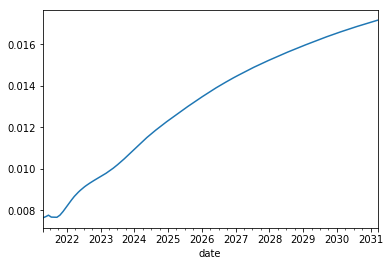

In [38]:
ir.curve.plot()

## Forward

In [176]:
myModel.data_adapter.get_forward_data_from_file('gbp')

contact_start   price
0      02/06/2021  63.450
1      03/06/2021  64.250
2      04/06/2021  64.250
3      05/06/2021  64.250
4      06/06/2021  64.250
..            ...     ...
299    28/03/2022  69.815
300    29/03/2022  69.815
301    30/03/2022  69.815
302    31/03/2022  69.815
303    01/04/2022  53.940

[304 rows x 2 columns]

In [178]:
forward.smooth_curve = True

In [182]:
fwd_c = myModel.data_adapter.get_forward_data(myModel.storage.fwd_curve, myModel.val_date)

Sending Initial Context Token - error=590610 authenticated=False


2021-06-29 14:52:41,945: gmt.util.common.net.auth: 145: INFO: Sending Initial Context Token - error=590610 authenticated=False.


Sending Second Context Token - error=0 authenticated=True


2021-06-29 14:52:41,960: gmt.util.common.net.auth: 125: INFO: Sending Second Context Token - error=0 authenticated=True.


Sending Initial Context Token - error=590610 authenticated=False


2021-06-29 14:52:42,088: gmt.util.common.net.auth: 145: INFO: Sending Initial Context Token - error=590610 authenticated=False.


Sending Second Context Token - error=0 authenticated=True


2021-06-29 14:52:42,103: gmt.util.common.net.auth: 125: INFO: Sending Second Context Token - error=0 authenticated=True.


In [188]:
fwd_c.set_index('index').resample('D').sum().reset_index()

index  G_H_NBP.Pnc
0    2021-06-28        82.30
1    2021-06-29        79.15
2    2021-06-30        79.15
3    2021-07-01        79.60
4    2021-07-02        79.60
...         ...          ...
2098 2027-03-27        49.84
2099 2027-03-28        49.84
2100 2027-03-29        49.84
2101 2027-03-30        49.84
2102 2027-03-31        49.84

[2103 rows x 2 columns]

In [179]:
forward._format_fwd_curve(myModel.data_adapter.get_forward_data(myModel.storage.fwd_curve, myModel.val_date))

Sending Initial Context Token - error=590610 authenticated=False


2021-06-29 14:51:28,037: gmt.util.common.net.auth: 145: INFO: Sending Initial Context Token - error=590610 authenticated=False.


Sending Second Context Token - error=0 authenticated=True


2021-06-29 14:51:28,052: gmt.util.common.net.auth: 125: INFO: Sending Second Context Token - error=0 authenticated=True.


Sending Initial Context Token - error=590610 authenticated=False


2021-06-29 14:51:28,359: gmt.util.common.net.auth: 145: INFO: Sending Initial Context Token - error=590610 authenticated=False.


Sending Second Context Token - error=0 authenticated=True


2021-06-29 14:51:28,374: gmt.util.common.net.auth: 125: INFO: Sending Second Context Token - error=0 authenticated=True.
2021-06-29 14:51:28,397: c:\git\gmt-fom-gas-research\gmt\fom\gas\shared\models\git_storage\data\fwd.py: 48: INFO: Format forward curve....


OutOfMemoryException: Array dimensions exceeded supported range.
   at MathNet.Numerics.LinearAlgebra.MatrixBuilder`1.SameAs(Matrix`1 example, Matrix`1 otherExample, Int32 rows, Int32 columns, Boolean fullyMutable)
   at MathNet.Numerics.LinearAlgebra.Matrix`1.Stack(Matrix`1 lower)
   at Cmdty.Curves.MaxSmoothnessSplineCurveBuilder`1.Build(List`1 contracts, Func`2 weighting, Func`2 multAdjustFunc, Func`2 addAdjustFunc, Func`3 timeFunc, Nullable`1 frontFirstDerivative, Nullable`1 backFirstDerivative)
   at Cmdty.Curves.MaxSmoothnessSplineCurveBuilder`1.BuildCurve()

In [175]:
myModel.data_adapter.get_forward_data(myModel.storage.fwd_curve, myModel.val_date)

Sending Initial Context Token - error=590610 authenticated=False


2021-06-29 14:48:29,824: gmt.util.common.net.auth: 145: INFO: Sending Initial Context Token - error=590610 authenticated=False.


Sending Second Context Token - error=0 authenticated=True


2021-06-29 14:48:29,853: gmt.util.common.net.auth: 125: INFO: Sending Second Context Token - error=0 authenticated=True.


Sending Initial Context Token - error=590610 authenticated=False


2021-06-29 14:48:29,977: gmt.util.common.net.auth: 145: INFO: Sending Initial Context Token - error=590610 authenticated=False.


Sending Second Context Token - error=0 authenticated=True


2021-06-29 14:48:29,994: gmt.util.common.net.auth: 125: INFO: Sending Second Context Token - error=0 authenticated=True.


index  G_H_NBP.Pnc
0    2021-06-28        82.30
1    2021-06-29        79.15
2    2021-06-30        79.15
3    2021-07-01        79.60
4    2021-07-02        79.60
...         ...          ...
2098 2027-03-27        49.84
2099 2027-03-28        49.84
2100 2027-03-29        49.84
2101 2027-03-30        49.84
2102 2027-03-31        49.84

[2103 rows x 2 columns]

In [27]:
from gmt.fom.gas.shared.models.git_storage.data.fwd import Forward

In [194]:
curve='G_H_NBP.Pnc'
day = date.today()

In [274]:
fwd1 = DataAdapter.get_forward_data(curve, day)

Sending Initial Context Token - error=590610 authenticated=False


2021-06-30 12:05:10,110: gmt.util.common.net.auth: 145: INFO: Sending Initial Context Token - error=590610 authenticated=False.


Sending Second Context Token - error=0 authenticated=True


2021-06-30 12:05:10,131: gmt.util.common.net.auth: 125: INFO: Sending Second Context Token - error=0 authenticated=True.


Sending Initial Context Token - error=590610 authenticated=False


2021-06-30 12:05:10,257: gmt.util.common.net.auth: 145: INFO: Sending Initial Context Token - error=590610 authenticated=False.


Sending Second Context Token - error=0 authenticated=True


2021-06-30 12:05:10,265: gmt.util.common.net.auth: 125: INFO: Sending Second Context Token - error=0 authenticated=True.


In [224]:
fwd2 = DataAdapter.get_forward_data_from_file(ccy='gbp')

In [263]:
fwd2['contact_start'] = pd.to_datetime(fwd2['contact_start'], format='%d/%m/%Y')

In [303]:
fwd2.head(300).tail()

contact_start   price
295    2022-03-24  69.815
296    2022-03-25  69.815
297    2022-03-26  69.815
298    2022-03-27  69.815
299    2022-03-28  69.815

In [264]:
fwd_curve = fwd2

In [276]:
fwd1['index'] = pd.to_datetime(fwd1['index'])

In [294]:
fwd_curve = fwd1.head(300)

In [295]:
freq = 'D'
fwd_periods = []
fwd_prices = []

for fwd_start, fwd_price in fwd_curve.values.tolist():
    fwd_periods.append(pd.Period(fwd_start, freq=freq))
    fwd_prices.append(fwd_price)

In [301]:
fwd_curve.values.tolist()[:-10]

[79.15,
 82.875,
 82.84999999999998,
 82.85000000000001,
 82.85,
 82.84999999999998,
 82.85,
 82.85,
 82.85,
 82.84999999999997,
 82.84999999999997,
 82.84999999999998,
 82.85,
 82.84999999999998,
 82.85,
 82.85,
 82.85,
 82.85000000000001,
 82.84999999999998,
 82.84999999999998,
 82.85,
 82.85,
 82.84999999999998,
 82.85000000000001,
 82.85,
 82.84999999999998,
 82.84999999999998,
 82.84999999999998,
 82.84999999999998,
 82.84999999999997,
 82.84999999999967,
 82.8500000000009,
 82.85000000000106,
 82.565000000002,
 82.56500000000017,
 82.56499999999997,
 82.56499999999994,
 82.56500000000003,
 82.565,
 82.56499999999998,
 82.565,
 82.56500000000001,
 82.565,
 82.56499999999998,
 82.56500000000001,
 82.56499999999996,
 82.565,
 82.56500000000001,
 82.56500000000001,
 82.565,
 82.56499999999998,
 82.56499999999997,
 82.56499999999998,
 82.565,
 82.56500000000001,
 82.56500000000001,
 82.565,
 82.56499999999998,
 82.56499999999994,
 82.56499999999976,
 82.56500000000139,
 82.56500000001

In [297]:
import itertools

In [298]:
from gmt.fom.gas.shared.models.git_storage.data.fwd import *

In [299]:
len(fwd_periods)

300

In [300]:
if True:
    p1, p2 = itertools.tee(fwd_periods)
    next(p2, None)
    contracts = []
    for start, end, price in zip(p1, p2, fwd_prices):
        if start > end-1:
            print(start)
        
        contracts.append((start, end - 1, price))
    weekend_adjust = None
    
    
    fwd_curve = max_smooth_interp(contracts,
                                  freq=freq,
                                  mult_season_adjust=weekend_adjust)
else:
    fwd_curve = pd.Series(fwd_prices, pd.PeriodIndex(fwd_periods)).resample('D').fillna('pad')

In [302]:
fwd_curve

2021-06-29    79.1500
2021-06-30    82.8750
2021-07-01    82.8500
2021-07-02    82.8500
2021-07-03    82.8500
               ...   
2022-04-19    63.5233
2022-04-20    63.5233
2022-04-21    63.5233
2022-04-22    63.5233
2022-04-23    63.5233
Freq: D, Length: 299, dtype: float64

In [205]:
fwd2.sort_index

contact_start   price
0      02/06/2021  63.450
1      03/06/2021  64.250
2      04/06/2021  64.250
3      05/06/2021  64.250
4      06/06/2021  64.250
..            ...     ...
299    28/03/2022  69.815
300    29/03/2022  69.815
301    30/03/2022  69.815
302    31/03/2022  69.815
303    01/04/2022  53.940

[304 rows x 2 columns]

datetime.date(2021, 6, 2)

In [211]:
forward.start_date = date(2021,6,2)

In [212]:
forward.smooth_curve = True

In [214]:
forward._format_fwd_curve(fwd2)

2021-06-30 11:35:58,655: c:\git\gmt-fom-gas-research\gmt\fom\gas\shared\models\git_storage\data\fwd.py: 48: INFO: Format forward curve....


[(Period('2021-02-06', 'D'), Period('2021-03-05', 'D'), 63.45), (Period('2021-03-06', 'D'), Period('2021-04-05', 'D'), 64.25), (Period('2021-04-06', 'D'), Period('2021-05-05', 'D'), 64.25), (Period('2021-05-06', 'D'), Period('2021-06-05', 'D'), 64.25), (Period('2021-06-06', 'D'), Period('2021-07-05', 'D'), 64.25), (Period('2021-07-06', 'D'), Period('2021-08-05', 'D'), 64.25), (Period('2021-08-06', 'D'), Period('2021-09-05', 'D'), 64.25), (Period('2021-09-06', 'D'), Period('2021-10-05', 'D'), 64.25), (Period('2021-10-06', 'D'), Period('2021-11-05', 'D'), 64.25), (Period('2021-11-06', 'D'), Period('2021-12-05', 'D'), 64.25), (Period('2021-12-06', 'D'), Period('2021-06-12', 'D'), 64.25), (Period('2021-06-13', 'D'), Period('2021-06-13', 'D'), 64.25), (Period('2021-06-14', 'D'), Period('2021-06-14', 'D'), 64.25), (Period('2021-06-15', 'D'), Period('2021-06-15', 'D'), 64.25), (Period('2021-06-16', 'D'), Period('2021-06-16', 'D'), 64.25), (Period('2021-06-17', 'D'), Period('2021-06-17', 'D'),

ArgumentException: start cannot be after end
   at Cmdty.Curves.Contract`1..ctor(T start, T end, Double price)
   at Cmdty.Curves.MaxSmoothnessSplineCurveBuilderExtensions.AddContract[T](MaxSmoothnessSplineCurveBuilder`1 splineCurveBuilder, T start, T end, Double price)

In [307]:
forward = Forward(curve_name='G_H_NBP.Pnc', 
                  start_date = date.today(),
                  smooth_curve=True, 
                  apply_weekend_shaping=True, 
                  weekend_shaping_factor=0.999)

2021-06-30 12:10:18,601: c:\git\gmt-fom-gas-research\gmt\fom\gas\shared\models\git_storage\data\fwd.py: 42: INFO: Getting forward curve data....


Sending Initial Context Token - error=590610 authenticated=False


2021-06-30 12:10:18,639: gmt.util.common.net.auth: 145: INFO: Sending Initial Context Token - error=590610 authenticated=False.


Sending Second Context Token - error=0 authenticated=True


2021-06-30 12:10:18,652: gmt.util.common.net.auth: 125: INFO: Sending Second Context Token - error=0 authenticated=True.


Sending Initial Context Token - error=590610 authenticated=False


2021-06-30 12:10:18,777: gmt.util.common.net.auth: 145: INFO: Sending Initial Context Token - error=590610 authenticated=False.


Sending Second Context Token - error=0 authenticated=True


2021-06-30 12:10:18,784: gmt.util.common.net.auth: 125: INFO: Sending Second Context Token - error=0 authenticated=True.
2021-06-30 12:10:18,807: c:\git\gmt-fom-gas-research\gmt\fom\gas\shared\models\git_storage\data\fwd.py: 48: INFO: Format forward curve....


In [308]:
forward.params

{'smooth_curve': True,
 'apply_weekend_shaping': True,
 'weekend_shaping_factor': 0.999,
 'curve_name': 'G_H_NBP.Pnc'}

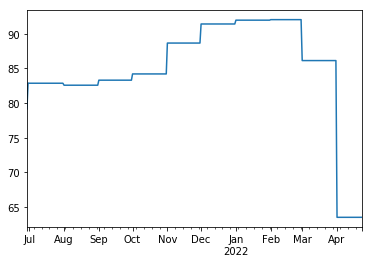

In [306]:
(forward.curve/29.3071).plot()

In [36]:
forward.curve

2021-06-02    1859.535495
2021-06-03    1882.981175
2021-06-04    1882.981175
2021-06-05    1882.981175
2021-06-06    1882.981175
                 ...     
2022-03-27    2046.075187
2022-03-28    2046.075187
2022-03-29    2046.075186
2022-03-30    2046.075187
2022-03-31    2046.075187
Freq: D, Length: 303, dtype: float64

# Putting all together Model

In [39]:
from gmt.fom.gas.shared.models.git_storage.model import GitStorageModel

In [40]:
from gmt.fom.gas.shared.models.git_storage.model import *

In [41]:
myModel = GitStorageModel(
                          val_date=date.today().strftime(format='%Y-%m-%d'),
                          inventory=storage.inventory,
                          
                          discount_deltas=False,
                          
                          ir = ir,
                          forward=forward,
                          
                          diffusion=diffusion,
                          calibrator=calibrator,
                            
                          storage=storage, 
                          )

In [42]:
myModel.fit()

2021-06-29 11:29:46,683: c:\git\gmt-fom-gas-research\gmt\fom\gas\shared\models\git_storage\model.py: 101: INFO: Fitting....
2021-06-29 11:29:46,881: cmdty.storage.multi-factor: 400: INFO: Compiling basis functions. Takes a few seconds on the first run..
2021-06-29 11:29:51,262: cmdty.storage.multi-factor: 402: INFO: Compilation of basis functions complete..
2021-06-29 11:29:51,263: cmdty.storage.multi-factor: 405: INFO: Calculating intrinsic value..
2021-06-29 11:29:51,493: cmdty.storage.multi-factor: 410: INFO: Calculation of intrinsic value complete..
2021-06-29 11:29:51,494: cmdty.storage.multi-factor: 413: INFO: Calculating LSMC value..
2021-06-29 11:29:51,547: cmdty.storage.multi-factor: 325: INFO: Starting regression spot price simulation..
2021-06-29 11:29:51,735: cmdty.storage.multi-factor: 325: INFO: Spot regression price simulation complete..
2021-06-29 11:29:51,740: cmdty.storage.multi-factor: 325: INFO: Starting backward induction..
2021-06-29 11:30:02,367: cmdty.storage.mu

Full Value=7,461,933.9449
Intrinsic Value=5,002,581.4460
Extrinsic Value=2,459,352.4989


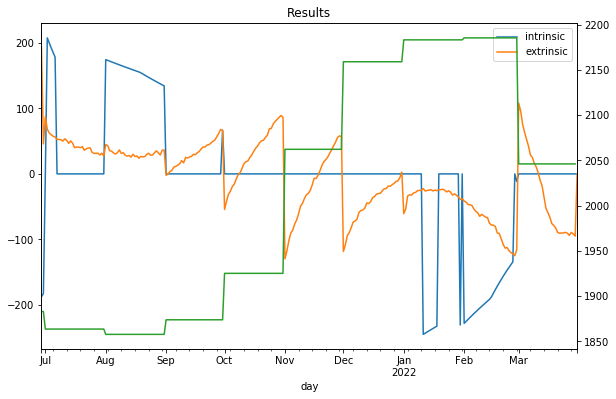

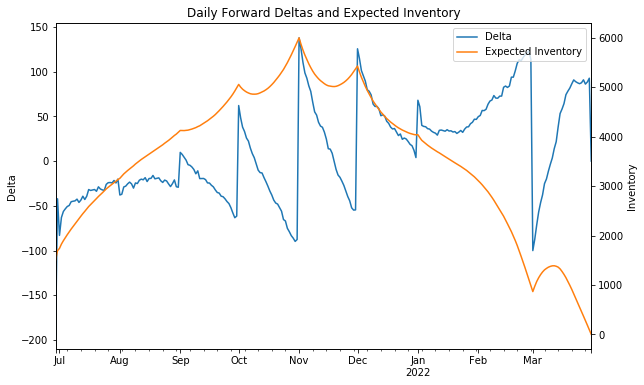

In [51]:
myModel.plot()

In [53]:
myModel.save_results()

In [54]:
myModel.email_results()

# Retrieve job results

In [57]:
t_range = myModel.data_adapter.results_t_range; t_range

[datetime.date(2021, 6, 11),
 datetime.date(2021, 6, 12),
 datetime.date(2021, 6, 15),
 datetime.date(2021, 6, 16),
 datetime.date(2021, 6, 17),
 datetime.date(2021, 6, 18),
 datetime.date(2021, 6, 19),
 datetime.date(2021, 6, 22),
 datetime.date(2021, 6, 24),
 datetime.date(2021, 6, 25),
 datetime.date(2021, 6, 26),
 datetime.date(2021, 6, 28),
 datetime.date(2021, 6, 29)]

### Query:

In [58]:
t_range

[datetime.date(2021, 6, 11),
 datetime.date(2021, 6, 12),
 datetime.date(2021, 6, 15),
 datetime.date(2021, 6, 16),
 datetime.date(2021, 6, 17),
 datetime.date(2021, 6, 18),
 datetime.date(2021, 6, 19),
 datetime.date(2021, 6, 22),
 datetime.date(2021, 6, 24),
 datetime.date(2021, 6, 25),
 datetime.date(2021, 6, 26),
 datetime.date(2021, 6, 28),
 datetime.date(2021, 6, 29)]

In [59]:
query = dict(run_date=pd.to_datetime(t_range[-1]),
            storage_id='uk2', 
            storage_type='RATCHETS')
df = myModel.data_adapter.retrieve(query=query)
ddff(df)

inject_withdraw_volume         ext          fwd   run_date  \
day                                                                      
2021-06-29             -220.000000    0.000000  1882.981175 2021-06-29   
2021-06-30             -215.600000  -25.513333  1882.981175 2021-06-29   
2021-07-01                0.000000   35.049333  1863.638489 2021-06-29   
2021-07-02                0.000000   24.008987  1863.638489 2021-06-29   
2021-07-03                0.000000   23.198114  1863.638489 2021-06-29   
2021-07-04                0.000000   19.164497  1863.638489 2021-06-29   
2021-07-05                0.000000   18.654263  1863.638489 2021-06-29   
2021-07-06                0.000000   18.080841  1863.638489 2021-06-29   
2021-07-07                0.000000   16.422811  1863.638489 2021-06-29   
2021-07-08                0.000000   17.908064  1863.638489 2021-06-29   
2021-07-09                0.000000   16.047782  1863.638489 2021-06-29   
2021-07-10                0.000000   14.711242  1863.638489 2021-06-29   
2021-07-11                0.000000   17.713996  1863.638489 2021-06-29   
2021-07-12                0.000000   14.914017  1863.638489 2021-06-29   
2021-07-13             -211.288000   12.498895  1863.638489 2021-06-29   
2021-07-14                0.000000   15.603582  1863.638489 2021-06-29   
2021-07-15             -207.062240   12.239612  1863.638489 2021-06-29   
2021-07-16                0.000000   11.515474  1863.638489 2021-06-29   
2021-07-17                0.000000   14.789471  1863.638489 2021-06-29   
2021-07-18                0.000000   15.329195  1863.638489 2021-06-29   
2021-07-19                0.000000   16.313341  1863.638489 2021-06-29   
2021-07-20                0.000000   17.954650  1863.638489 2021-06-29   
2021-07-21                0.000000   12.500426  1863.638489 2021-06-29   
2021-07-22                0.000000   16.121316  1863.638489 2021-06-29   
2021-07-23                0.000000   15.202158  1863.638489 2021-06-29   
2021-07-24                0.000000   16.839242  1863.638489 2021-06-29   
2021-07-25                0.000000   13.376177  1863.638489 2021-06-29   
2021-07-26                0.000000   11.358294  1863.638489 2021-06-29   
2021-07-27                0.000000    8.547884  1863.638489 2021-06-29   
2021-07-28                0.000000    7.490883  1863.638489 2021-06-29   
2021-07-29                0.000000    4.688707  1863.638489 2021-06-29   
2021-07-30                0.000000    8.257160  1863.638489 2021-06-29   
2021-07-31                0.000000    4.705020  1863.638489 2021-06-29   
2021-08-01              174.026335   24.326485  1857.777069 2021-06-29   
2021-08-02              172.866159   26.320575  1857.777069 2021-06-29   
2021-08-03              171.713718   19.977196  1857.777069 2021-06-29   
2021-08-04              170.568960   19.191186  1857.777069 2021-06-29   
2021-08-05              169.431834   19.046482  1857.777069 2021-06-29   
2021-08-06              168.302288   18.619008  1857.777069 2021-06-29   
2021-08-07              167.180273   19.939564  1857.777069 2021-06-29   
2021-08-08              166.065738   23.635623  1857.777069 2021-06-29   
2021-08-09              164.958633   20.222591  1857.777069 2021-06-29   
2021-08-10              163.858909   22.237728  1857.777069 2021-06-29   
2021-08-11              162.766516   19.603072  1857.777069 2021-06-29   
2021-08-12              161.681406   18.891987  1857.777069 2021-06-29   
2021-08-13              160.603530   19.591227  1857.777069 2021-06-29   
2021-08-14              159.532840   17.941723  1857.777069 2021-06-29   
2021-08-15              158.469287   24.350091  1857.777069 2021-06-29   
2021-08-16              157.412825   20.432617  1857.777069 2021-06-29   
2021-08-17              156.363407   21.500922  1857.777069 2021-06-29   
2021-08-18              155.320984   18.833312  1857.777069 2021-06-29   
2021-08-19              153.767506   21.049990  1857.777069 2021-06-29   
2021-08-20      

## Definition of storages to csv

In [60]:
dataAdapter = DataAdapter()

In [61]:
dataAdapter.get_all_storages()

[{'ccy': 'GBP',
  'freq': 'D',
  'inventory': 1500,
  'storage_start': Timestamp('2021-06-02 00:00:00'),
  'storage_end': Timestamp('2022-03-31 00:00:00'),
  'injection_cost': 0.692359398,
  'withdrawal_cost': 0.202930711,
  'min_inventory': 0,
  'max_inventory': 4387000000,
  'max_injection_rate': 182000000,
  'max_withdrawal_rate': 182000000,
  'storage_id': 'uk1',
  'storage_type': 'SIMPLE'},
 {'ccy': 'GBP',
  'freq': 'D',
  'inventory': 3000,
  'storage_start': Timestamp('2021-06-02 00:00:00'),
  'storage_end': Timestamp('2022-03-31 00:00:00'),
  'injection_cost': 0.692359398,
  'withdrawal_cost': 0.202930711,
  'min_inventory': 0,
  'max_inventory': 4387000000,
  'max_injection_rate': 190000000,
  'max_withdrawal_rate': 200000000,
  'storage_id': 'uk1',
  'ratchets': [(Period('2021-06-01', 'D'),
    [(0, -150, 250), (2000, -200, 175), (5000, -260, 155), (7000, -275, 132)]),
   (Period('2022-03-01', 'D'),
    [(0, -130, 260),
     (2000, -190, 190),
     (5000, -230, 165),
     (70

# Import data from ARC

In [62]:
import nest_asyncio
nest_asyncio.apply()

In [63]:
from datetime import date, datetime

In [66]:
from gmt.dna.datagateway.data_adapter_factory import DataAdapterFactory
d = DataAdapterFactory.create("arc", env='prod')

Sending Initial Context Token - error=590610 authenticated=False


2021-06-29 11:37:47,396: gmt.util.common.net.auth: 145: INFO: Sending Initial Context Token - error=590610 authenticated=False.


Sending Second Context Token - error=0 authenticated=True


2021-06-29 11:37:47,425: gmt.util.common.net.auth: 125: INFO: Sending Second Context Token - error=0 authenticated=True.


Sending Initial Context Token - error=590610 authenticated=False


2021-06-29 11:37:47,454: gmt.util.common.net.auth: 145: INFO: Sending Initial Context Token - error=590610 authenticated=False.


Sending Second Context Token - error=0 authenticated=True


2021-06-29 11:37:47,469: gmt.util.common.net.auth: 125: INFO: Sending Second Context Token - error=0 authenticated=True.


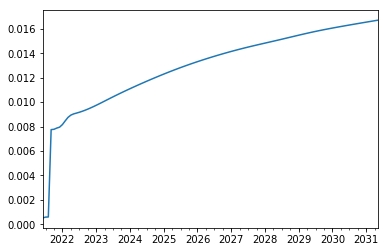

In [71]:
d.get_forward_curve("Treasury_Analyst_GBP_M", date.today()).plot()

Sending Initial Context Token - error=590610 authenticated=False


2021-06-29 11:37:44,701: gmt.util.common.net.auth: 145: INFO: Sending Initial Context Token - error=590610 authenticated=False.


Sending Second Context Token - error=0 authenticated=True


2021-06-29 11:37:44,717: gmt.util.common.net.auth: 125: INFO: Sending Second Context Token - error=0 authenticated=True.


Sending Initial Context Token - error=590610 authenticated=False


2021-06-29 11:37:44,749: gmt.util.common.net.auth: 145: INFO: Sending Initial Context Token - error=590610 authenticated=False.


Sending Second Context Token - error=0 authenticated=True


2021-06-29 11:37:44,764: gmt.util.common.net.auth: 125: INFO: Sending Second Context Token - error=0 authenticated=True.


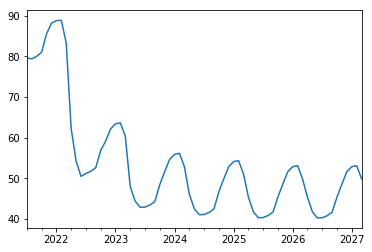

In [70]:
d.get_forward_curve("G_H_NBP-Monthly.Pnc", date.today()).plot()